In [1]:
from IPython.display import clear_output

## Subject 1

In [2]:
SUBJECT = 1
TRIAL = 1

In [3]:
%run 'mahnob v4_4.ipynb'
clear_output(wait=False)

In [4]:
epochs_1 = epochs
raw_1 = raw
events_1 = events

## Subject 2

In [6]:
SUBJECT = 2
TRIAL = 2

In [7]:
%run 'mahnob v4_4.ipynb'
clear_output(wait=False)

In [8]:
epochs_2 = epochs
raw_2 = raw
events_2 = events

## Subject 3

In [10]:
SUBJECT = 3
TRIAL = 1

In [11]:
%run 'mahnob v4_4.ipynb'
clear_output(wait=False)

In [12]:
epochs_3 = epochs
raw_3 = raw
events_3 = events

## Subject 4

In [14]:
SUBJECT = 4
TRIAL = 1

In [15]:
%run 'mahnob v4_4.ipynb'
clear_output(wait=False)

In [16]:
epochs_4 = epochs
raw_4 = raw
events_4 = events

## Set test size and training window

In [132]:
TEST_SIZE = 0.6
TRAIN_TMIN = -0.5
TRAIN_TMAX = 0.5

## Combination 1

In [133]:
epochs = mne.concatenate_epochs([epochs_1], add_offset=True, on_mismatch='ignore')
raw = mne.concatenate_raws([raw_1], on_mismatch='ignore')
# events = np.concatenate([events_1, events_2])

Not setting metadata
10 matching events found
No baseline correction applied


In [134]:
events = mne.find_events(raw, stim_channel=["AllKeyPress"])
event_id = dict(k=2, nk=1)

70 events found
Event IDs: [1 2]


In [135]:
# events

In [136]:
# event_id

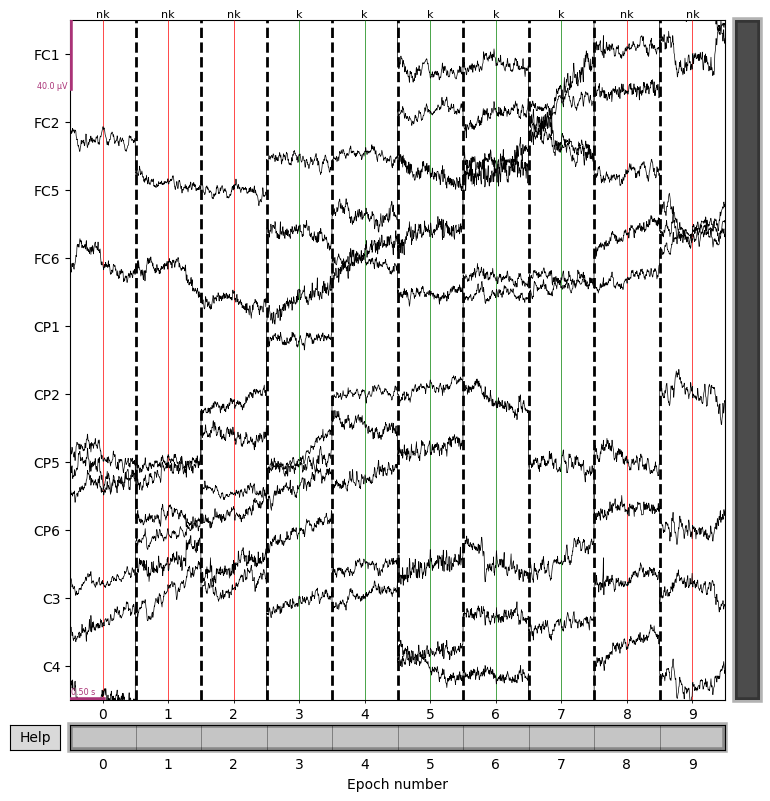

In [137]:
fig = epochs.plot(events=events, event_id=event_id, event_color=dict(k="green", nk="red"));
# fig = epochs.plot();
fig.savefig('allkeypress_combined_epochs.pdf')

In [138]:
epochs_train = epochs.copy().crop(tmin=TRAIN_TMIN, tmax=TRAIN_TMAX)
labels = epochs.events[:, -1]

In [139]:
labels

array([1, 1, 1, 2, 2, 2, 2, 2, 1, 1])

In [140]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=TEST_SIZE, random_state=42)
cv_split = cv.split(epochs_data_train)

In [141]:
# Assemble a classifier
lda = LDA()
svc = SVC()
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False)

In [142]:
# Use scikit-learn Pipeline with cross_val_score function
# clf = Pipeline([("CSP", csp), ("LDA", lda)])

clf_lda = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    lda
)

clf_svc = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    svc
)

In [143]:
scores_lda = cross_val_score(clf_lda, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0016 (2.2e-16 eps * 5 dim * 1.4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0043 (2.2e-16 eps * 5 dim * 3.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0022 (2.2e-16 eps * 5 dim * 2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag):

In [144]:
scores_svc = cross_val_score(clf_svc, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svc), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0016 (2.2e-16 eps * 5 dim * 1.4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0043 (2.2e-16 eps * 5 dim * 3.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0022 (2.2e-16 eps * 5 dim * 2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag):

In [145]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows_lda = []
scores_windows_svc = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = epochs_data_train[train_idx]
    X_test = epochs_data_train[test_idx]

    # fit classifier
    clf_lda.fit(X_train, y_train)
    clf_svc.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window_lda = []
    score_this_window_svc = []
    
    for n in w_start:
        X_test = epochs_data[test_idx][:, :, n : (n + w_length)]
        score_this_window_lda.append(clf_lda.score(X_test, y_test))
        score_this_window_svc.append(clf_svc.score(X_test, y_test))

    scores_windows_lda.append(score_this_window_lda)
    scores_windows_svc.append(score_this_window_svc)


Computing rank from data with rank=None
    Using tolerance 0.0016 (2.2e-16 eps * 5 dim * 1.4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0043 (2.2e-16 eps * 5 dim * 3.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0016 (2.2e-16 eps * 5 dim * 1.4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0043 (2.2e-16 eps * 5 dim * 3.9e+12  max singular value)
    Estimated rank (mag

In [146]:
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
w_start

array([  0,  25,  50,  75, 100, 125])

In [147]:
# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin
w_times

array([-0.25      , -0.15234375, -0.0546875 ,  0.04296875,  0.140625  ,
        0.23828125])

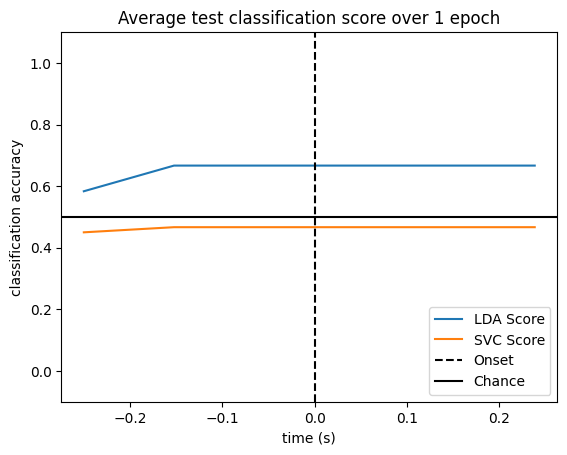

In [148]:
fig = plt.figure()
plt.plot(w_times, np.mean(scores_windows_lda, 0), label="LDA Score")
plt.plot(w_times, np.mean(scores_windows_svc, 0), label="SVC Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.ylim(-0.1,1.1)
plt.title("Average test classification score over 1 epoch")
plt.legend(loc="lower right")
plt.show()
# plt.savefig('images/classifier_score_window.eps', format='eps')
fig.savefig('allkeypress_combined_score_window_images/allkeypress_combined_score_window_{}'.format(str(TEST_SIZE))+'_'+str(1)+'.pdf')

## Combination 2

In [149]:
epochs = mne.concatenate_epochs([epochs_1, epochs_2], add_offset=True, on_mismatch='ignore')
raw = mne.concatenate_raws([raw_1, raw_2], on_mismatch='ignore')
# events = np.concatenate([events_1, events_2])

Not setting metadata
20 matching events found
No baseline correction applied


In [150]:
events = mne.find_events(raw, stim_channel=["AllKeyPress"])
event_id = dict(k=2, nk=1)

80 events found
Event IDs: [1 2]


In [151]:
# events

In [152]:
# event_id

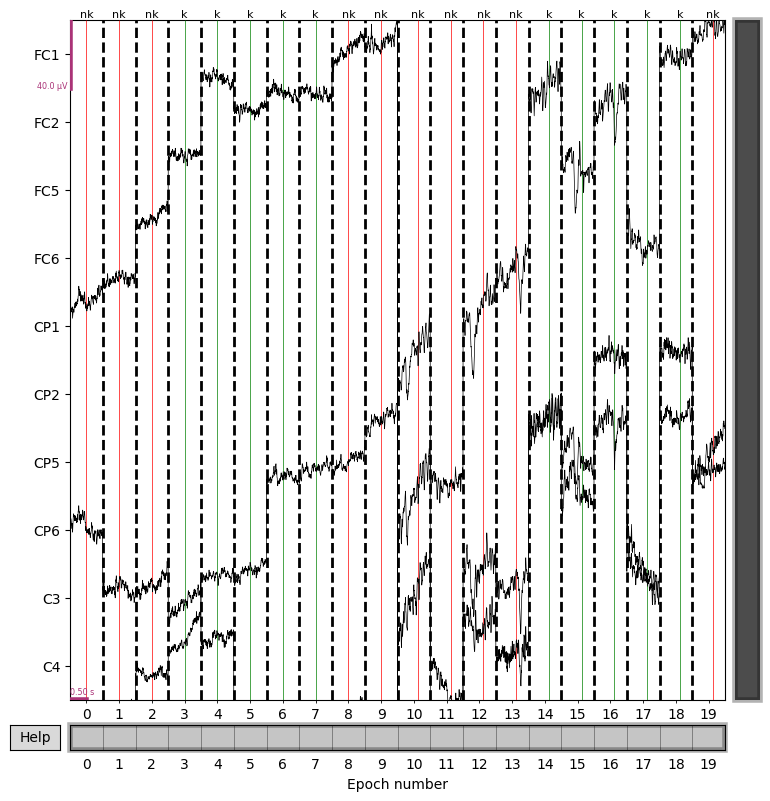

In [153]:
fig = epochs.plot(events=events, event_id=event_id, event_color=dict(k="green", nk="red"));
# fig = epochs.plot();
fig.savefig('allkeypress_combined_epochs.pdf')

In [154]:
epochs_train = epochs.copy().crop(tmin=TRAIN_TMIN, tmax=TRAIN_TMAX)
labels = epochs.events[:, -1]

In [155]:
labels

array([1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1])

In [156]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=TEST_SIZE, random_state=42)
cv_split = cv.split(epochs_data_train)

In [157]:
# Assemble a classifier
lda = LDA()
svc = SVC()
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False)

In [158]:
# Use scikit-learn Pipeline with cross_val_score function
# clf = Pipeline([("CSP", csp), ("LDA", lda)])

clf_lda = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    lda
)

clf_svc = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    svc
)

In [159]:
scores_lda = cross_val_score(clf_lda, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0038 (2.2e-16 eps * 5 dim * 3.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag)

Computing rank from data with rank=None
    Using tolerance 0.0027 (2.2e-16 eps * 5 dim * 2.4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0055 (2.2e-16 eps * 5 dim * 5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0038 (2.2e-16 eps * 5 dim * 3.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag):

In [160]:
scores_svc = cross_val_score(clf_svc, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svc), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.


Computing rank from data with rank=None
    Using tolerance 0.0038 (2.2e-16 eps * 5 dim * 3.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0043 (2.2e-16 eps * 5 dim * 3.9e+12  max singular value)
    Estimated rank (mag

In [161]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows_lda = []
scores_windows_svc = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = epochs_data_train[train_idx]
    X_test = epochs_data_train[test_idx]

    # fit classifier
    clf_lda.fit(X_train, y_train)
    clf_svc.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window_lda = []
    score_this_window_svc = []
    
    for n in w_start:
        X_test = epochs_data[test_idx][:, :, n : (n + w_length)]
        score_this_window_lda.append(clf_lda.score(X_test, y_test))
        score_this_window_svc.append(clf_svc.score(X_test, y_test))

    scores_windows_lda.append(score_this_window_lda)
    scores_windows_svc.append(score_this_window_svc)


Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0031 (2.2e-16 eps * 5 dim * 2.8e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag):

    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0043 (2.2e-16 eps * 5 dim * 3.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 dat

In [162]:
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
w_start

array([  0,  25,  50,  75, 100, 125])

In [163]:
# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin
w_times

array([-0.25      , -0.15234375, -0.0546875 ,  0.04296875,  0.140625  ,
        0.23828125])

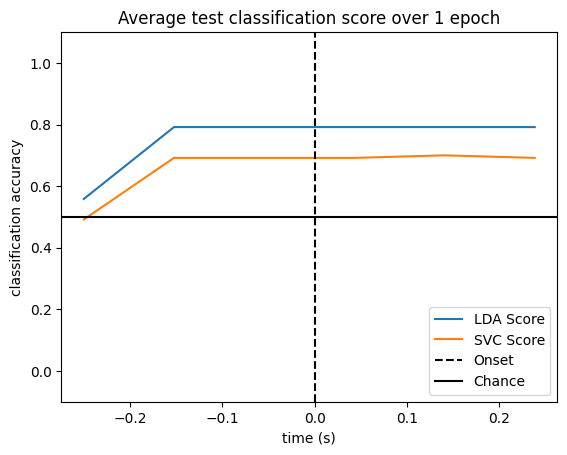

In [164]:
fig = plt.figure()
plt.plot(w_times, np.mean(scores_windows_lda, 0), label="LDA Score")
plt.plot(w_times, np.mean(scores_windows_svc, 0), label="SVC Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.ylim(-0.1,1.1)
plt.title("Average test classification score over 1 epoch")
plt.legend(loc="lower right")
plt.show()
# plt.savefig('images/classifier_score_window.eps', format='eps')
fig.savefig('allkeypress_combined_score_window_images/allkeypress_combined_score_window_{}'.format(str(TEST_SIZE))+'_'+str(2)+'.pdf')

## Combination 3

In [165]:
epochs = mne.concatenate_epochs([epochs_1, epochs_2, epochs_4], add_offset=True, on_mismatch='ignore')
raw = mne.concatenate_raws([raw_1, raw_2, raw_4], on_mismatch='ignore')
# events = np.concatenate([events_1, events_2])

Not setting metadata
30 matching events found
No baseline correction applied


In [166]:
events = mne.find_events(raw, stim_channel=["AllKeyPress"])
event_id = dict(k=2, nk=1)

100 events found
Event IDs: [1 2]


In [167]:
# events

In [168]:
# event_id

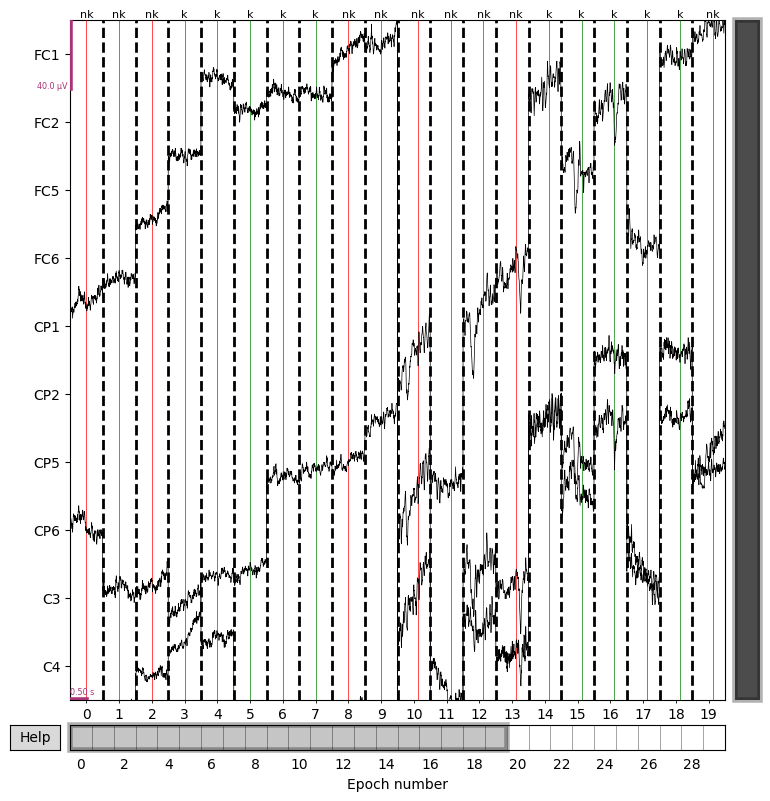

In [169]:
fig = epochs.plot(events=events, event_id=event_id, event_color=dict(k="green", nk="red"));
# fig = epochs.plot();
fig.savefig('allkeypress_combined_epochs.pdf')

In [170]:
epochs_train = epochs.copy().crop(tmin=TRAIN_TMIN, tmax=TRAIN_TMAX)
labels = epochs.events[:, -1]

In [171]:
labels

array([1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 1, 1])

In [172]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=TEST_SIZE, random_state=42)
cv_split = cv.split(epochs_data_train)

In [173]:
# Assemble a classifier
lda = LDA()
svc = SVC()
csp = CSP(n_components=5, reg=None, log=True, norm_trace=False)

In [174]:
# Use scikit-learn Pipeline with cross_val_score function
# clf = Pipeline([("CSP", csp), ("LDA", lda)])

clf_lda = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    lda
)

clf_svc = make_pipeline(
    UnsupervisedSpatialFilter(PCA(5), average=False),
    csp,
    StandardScaler(),
    svc
)

In [175]:
scores_lda = cross_val_score(clf_lda, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_lda), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag

    Using tolerance 0.0074 (2.2e-16 eps * 5 dim * 6.7e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0044 (2.2e-16 eps * 5 dim * 4e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.005 (2.2e-16 eps * 5 dim * 4.5e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0041 (2.2e-16 eps * 5 dim * 3.7e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data c

In [176]:
scores_svc = cross_val_score(clf_svc, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(
    "Classification accuracy: %f / Chance level: %f" % (np.mean(scores_svc), class_balance)
)

Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag

In [177]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows_lda = []
scores_windows_svc = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = epochs_data_train[train_idx]
    X_test = epochs_data_train[test_idx]

    # fit classifier
    clf_lda.fit(X_train, y_train)
    clf_svc.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window_lda = []
    score_this_window_svc = []
    
    for n in w_start:
        X_test = epochs_data[test_idx][:, :, n : (n + w_length)]
        score_this_window_lda.append(clf_lda.score(X_test, y_test))
        score_this_window_svc.append(clf_svc.score(X_test, y_test))

    scores_windows_lda.append(score_this_window_lda)
    scores_windows_svc.append(score_this_window_svc)


Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag

Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0035 (2.2e-16 eps * 5 dim * 3.2e+12  max singular value)
    Estimated rank (mag): 5
    MAG: rank 5 computed from 5 data channels with 0 projectors
Reducing data rank from 5 -> 5
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0066 (2.2e-16 eps * 5 dim * 5.9e+12  max singular value)
    Estimated rank (mag

In [178]:
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)
w_start

array([  0,  25,  50,  75, 100, 125])

In [179]:
# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin
w_times

array([-0.25      , -0.15234375, -0.0546875 ,  0.04296875,  0.140625  ,
        0.23828125])

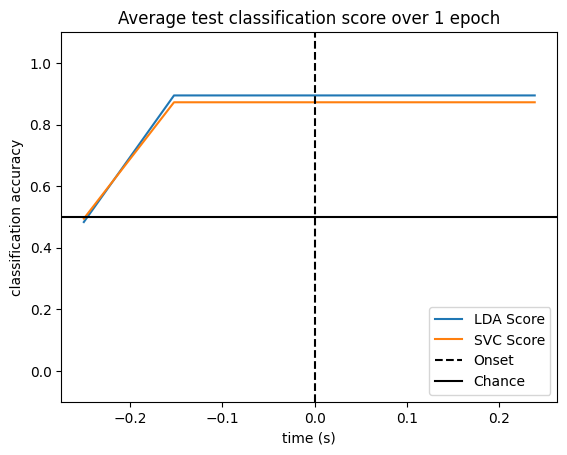

In [180]:
fig = plt.figure()
plt.plot(w_times, np.mean(scores_windows_lda, 0), label="LDA Score")
plt.plot(w_times, np.mean(scores_windows_svc, 0), label="SVC Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.ylim(-0.1,1.1)
plt.title("Average test classification score over 1 epoch")
plt.legend(loc="lower right")
plt.show()
# plt.savefig('images/classifier_score_window.eps', format='eps')
fig.savefig('allkeypress_combined_score_window_images/allkeypress_combined_score_window_{}'.format(str(TEST_SIZE))+'_'+str(3)+'.pdf')

## Combined spectrum

In [181]:
dir = 'combined_spectrum_plots'

In [182]:
epochs = mne.concatenate_epochs([epochs_1, epochs_2, epochs_4], add_offset=True, on_mismatch='ignore')

Not setting metadata
30 matching events found
No baseline correction applied


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


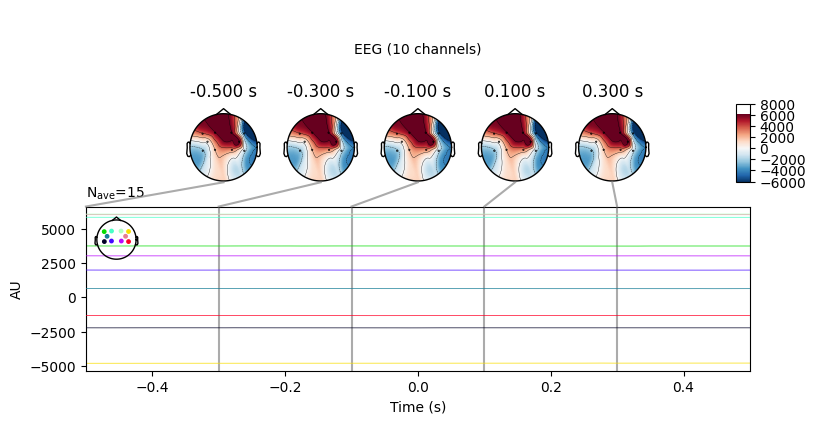

In [183]:
times = np.arange(-0.5, 0.5, 0.2)
fig = epochs['key'].average().plot_joint(times=times, ts_args=dict(scalings=dict(eeg=1e6), units=dict(eeg='AU')),
                                    topomap_args=dict(cbar_fmt='%3.1f'));
fig.savefig('{}/keypress_plot_joint_combined.pdf'.format(dir))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


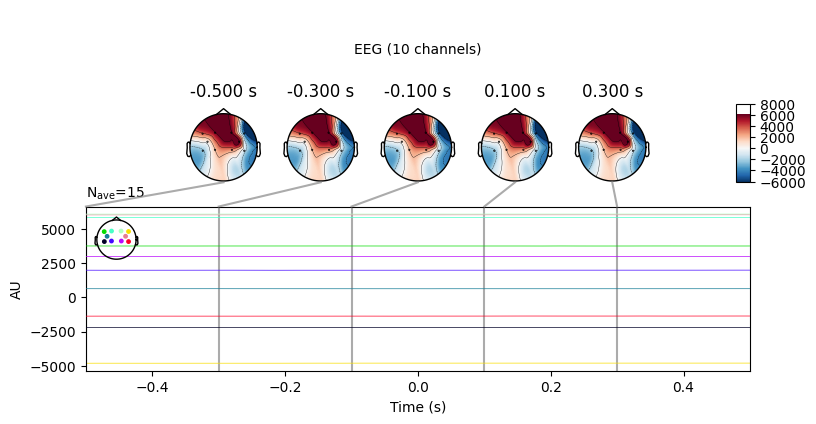

In [184]:
times = np.arange(-0.5, 0.5, 0.2)
fig = epochs['non_key'].average().plot_joint(times=times, ts_args=dict(scalings=dict(eeg=1e6), units=dict(eeg='AU')),
                                    topomap_args=dict(cbar_fmt='%3.1f'));
fig.savefig('{}/nonkeypress_plot_joint_combined.pdf'.format(dir))

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


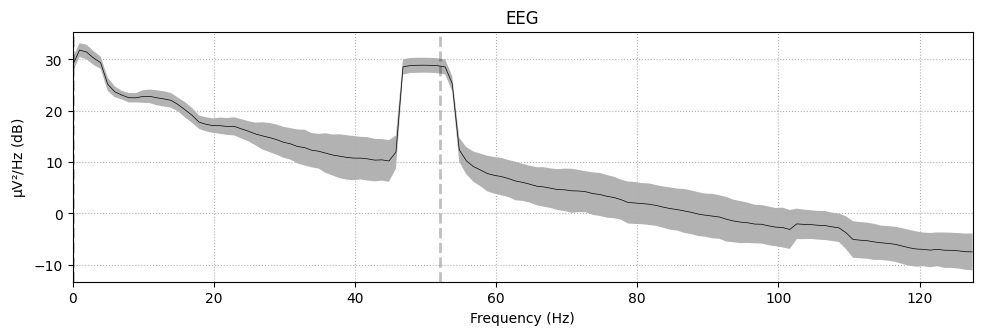

In [185]:
spectrum = epochs['key'].compute_psd()
fig = spectrum.plot(average=True, picks="data", exclude="bads")
plt.show()
fig.savefig('{}/keypress_spectrum_combined.pdf'.format(dir))

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


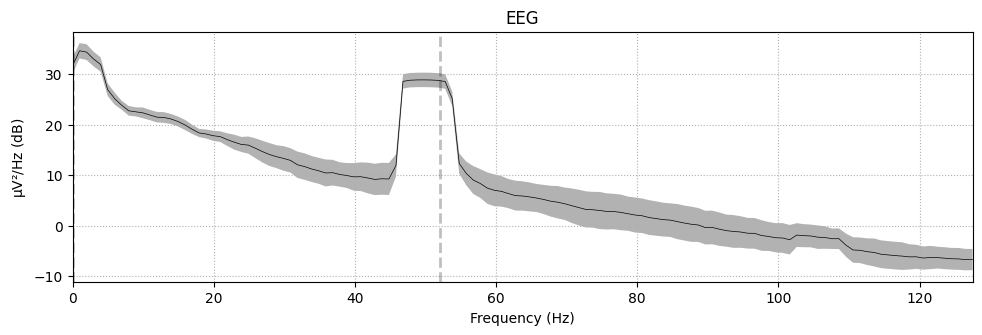

In [186]:
spectrum = epochs['non_key'].compute_psd()
fig = spectrum.plot(average=True, picks="data", exclude="bads")
plt.show()
fig.savefig('{}/nonkeypress_spectrum_combined.pdf'.format(dir))

    Using multitaper spectrum estimation with 7 DPSS windows


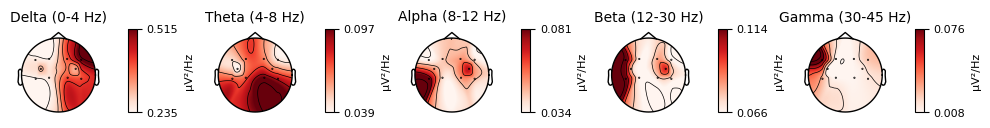

In [187]:
fig = epochs['key'].compute_psd().plot_topomap(normalize=True);
fig.savefig('{}/keypress_psd_topomap_combined.pdf'.format(dir))

    Using multitaper spectrum estimation with 7 DPSS windows


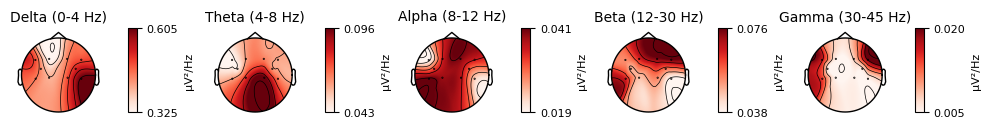

In [188]:
fig = epochs['non_key'].compute_psd().plot_topomap(normalize=True);
fig.savefig('{}/nonkeypress_psd_topomap_combined.pdf'.format(dir))